## Imports

In [31]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero

from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.train_test import train_test
from utils.visualize import plot_loss, plot_train, plot_val, plot_test

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the dataset

In [5]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4j')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title"],
    list_features=[],
    fastRP_features=[],
    numeric_features=[],
)
data = dataset[0].to(device)

Processing...


Movies have features...
Encoding title...


Batches: 100%|██████████| 565/565 [00:16<00:00, 35.09it/s]


[torch.Size([18062, 64])]


Done!


#### Preprocess the dataset

In [6]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In [14]:
train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=128,
    input_nodes=('movie', None),
)
batch = next(iter(train_loader))
# # Perform a link-level split into training, validation, and test edges:
# train_data, val_data, test_data = T.RandomLinkSplit(
#     num_val=0.1,
#     num_test=0.1,
#     neg_sampling_ratio=0.0,
#     edge_types=[('user', 'rates', 'movie')],
#     rev_edge_types=[('movie', 'rev_rates', 'user')],
# )(data)

In [29]:
dict(batch["user", "movie"]).keys()

dict_keys(['edge_index', 'edge_label'])

#### Define and train-test the model

In [9]:
model = Model(
    data,
    layer_name="SAGE",
    encoder_num_layers=6,
    encoder_dropout=0.1,
    encoder_skip_connections=[True],
    encoder_aggr=["mean"],
    decoder_num_layers=8,
    hidden_channels=16,
    out_channels=16,
).to(device)


Aggregation: mean


/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.012)

weight = torch.bincount(batch['user', 'movie'].edge_label)
weight = weight.max() / weight
def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [25]:
def train():
    model.train()

    total_examples = total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = batch['movie'].batch_size
        pred = model(batch.x_dict, batch.edge_index_dict, batch["user", "movie"].edge_label_index)
        target = batch['user', 'movie'].edge_label
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [26]:
train()

AttributeError: 'EdgeStorage' object has no attribute 'edge_label_index'

In [ ]:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight

def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

def train(log=False):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                    train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data, log=False):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()

    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

losses = []
for epoch in range(1, epochs+1):
    loss = train(log=not(epoch%20))
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data, log=not(epoch%20))
    losses.append((loss, train_rmse, val_rmse, test_rmse))
    if (logging_step and not epoch%logging_step) or (not logging_step):
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

#### Visualize

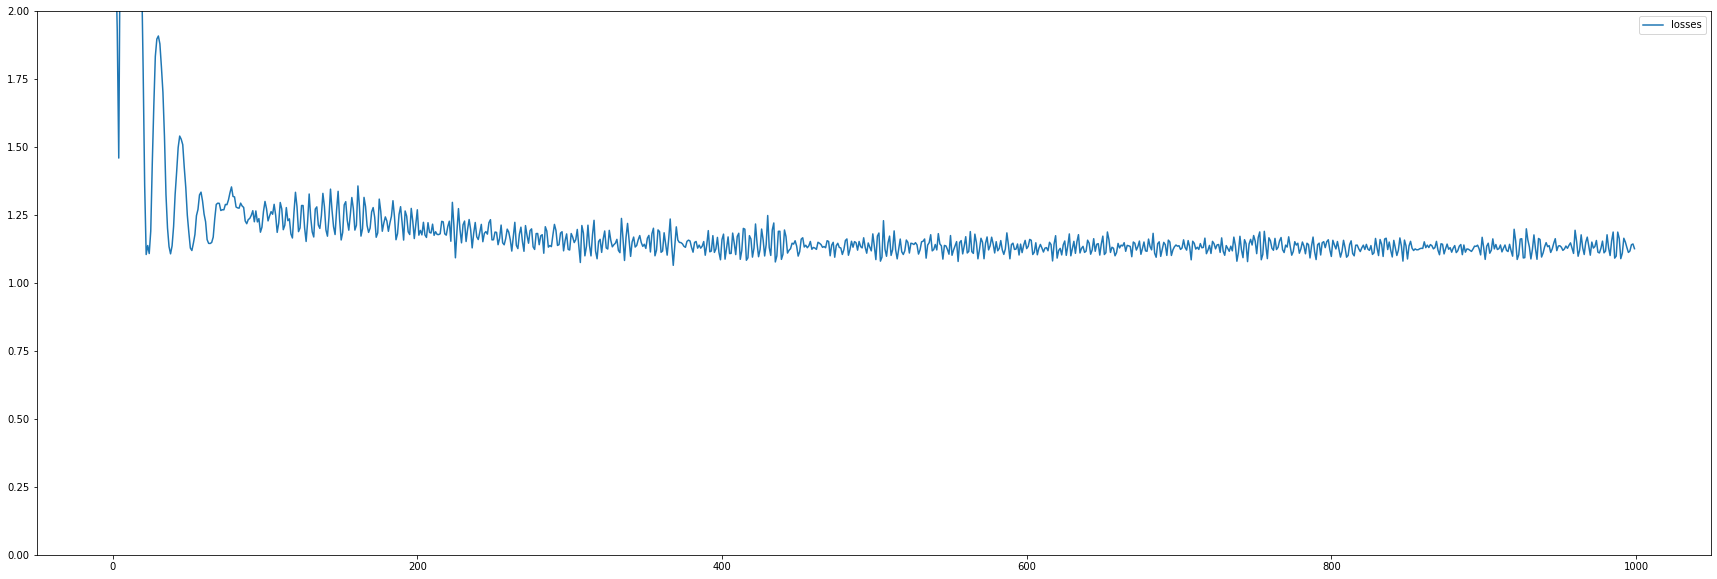

In [12]:
plot_test({ "losses": losses }, ylim=2)